## Bragg filtering based on Colin Ophus matlab code 
% Colin Ophus - 2023 June 9\
% plot image, inset FFT, and dual-bragg filtered image

Author: Tara mishra, tpmishra@lbl.gov

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
import os

In [2]:
### Electron micrograph 
im = loadmat('domain_0p4.mat')
im = im['array']
im = np.squeeze(im)
im = im.T

In [3]:
def makeFourierCoords(N, pixelSize):
    """
    Generate Fourier space coordinates for a given array size and pixel size.

    The function creates a coordinate grid suitable for Fourier space operations,
    taking into account whether the dimensions are even or odd. It supports both
    1D and 2D output, depending on the length of the input size array N.

    Parameters:
    - N (tuple of int): A tuple representing the size of the array. For 1D, it should
                        have one element; for 2D, it should have two elements.
    - pixelSize (float): The physical size of each pixel, used to scale the Fourier coordinates.

    Returns:
    - qx, qy (numpy.ndarray): Two numpy arrays representing the Fourier space coordinates
                              along the x and y dimensions. For a 1D input, both qx and qy
                              will be the same and represent the 1D coordinate grid.

    Example Usage:
    For a 2D array of size 256x256 with a pixel size of 0.1:
        N = (256, 256)
        pixelSize = 0.1
        qx, qy = makeFourierCoords(N, pixelSize)
    """

    # Generate qx
    if N[0] % 2 == 0:
        qx = np.fft.fftshift(np.arange(-N[0]//2, N[0]//2) / (N[0] * pixelSize))
    else:
        qx = np.fft.fftshift(np.arange((1-N[0])//2, (N[0]+1)//2) / (N[0] * pixelSize))

    # Generate qy if needed
    if len(N) > 1:
        if N[1] % 2 == 0:
            qy = np.fft.fftshift(np.arange(-N[1]//2, N[1]//2) / (N[1] * pixelSize))
        else:
            qy = np.fft.fftshift(np.arange((1-N[1])//2, (N[1]+1)//2) / (N[1] * pixelSize))
        qy, qx = np.meshgrid(qy, qx)
    else:
        qy = qx

    return qx, qy


In [4]:
import numpy as np

def tukeywinMake(windowSize, windowFrac=None):
    """
    Create a Tukey (Hann) window.

    This function redefines the Tukey (or Hann) window function for 1D or 2D inputs.

    Parameters:
    - windowSize (tuple of int): The size of the window. Can be a single integer for 1D, 
                                 or a tuple of two integers for 2D.
    - windowFrac (float or tuple of float, optional): The fractional size of the window. 
                                                      Default is [0, 0] for 1D, and it is replicated 
                                                      for each dimension if provided as a single value for 2D.

    Returns:
    - windowOutput (numpy.ndarray): The resulting Tukey window. 1D or 2D depending on the input.

    Example:
        For a 1D window of size 100 and window fraction 0.5:
        window = tukeywinMake(100, 0.5)
        
        For a 2D window of size (100, 200) with different window fractions for each dimension:
        window = tukeywinMake((100, 200), (0.5, 0.3))
    """
    if windowFrac is None:
        windowFrac = (0, 0)
    elif np.isscalar(windowFrac):
        windowFrac = (windowFrac, windowFrac)

    # Ensure windowSize is a tuple
    if np.isscalar(windowSize):
        windowSize = (windowSize,)

    # 1D window calculation
    x = np.linspace(1, windowSize[0], windowSize[0])
    windowOutput = np.minimum(1/(1 - windowFrac[0]) * (1 - np.abs((windowSize[0]+1)/2 - x) * 2 / windowSize[0]), 1)
    windowOutput = np.sin(windowOutput * (np.pi/2)) ** 2

    # 2D window calculation
    if len(windowSize) == 2:
        y = np.linspace(1, windowSize[1], windowSize[1])
        wy = np.minimum(1/(1 - windowFrac[1]) * (1 - np.abs((windowSize[1]+1)/2 - y) * 2 / windowSize[1]), 1)
        wy = np.sin(wy * (np.pi/2)) ** 2

        windowOutput = np.outer(windowOutput, wy)

    return windowOutput


In [5]:
# Define constants and parameters
qu = np.array([-43, 29])  # Red
qv = np.array([43, 29])   # Blue
qr = 10  # radius
qp = 2   # power
# Size of image
N = im.shape
x_range = [1, N[0]]
y_range = [1, N[1]]
int_range = [0, 0.0005]
int_fft = [0, 0.2]
int_sig = [0.0, 1.3]
sign_filt = 1
scale_circle = 1

## Color scheme
c = np.array([[1, 0.4, 0], [0, 0.6, 0.8]])

# Crop image if necessary
# im = im[x_range[0]-1:x_range[1], y_range[0]-1:y_range[1]]  # Uncomment if cropping is needed



# Generate Fourier coordinates for each dimension
qx = makeFourierCoords((N[0],), 1/N[0])[0]
qy = makeFourierCoords((N[1],), 1/N[1])[0]
qya, qxa = np.meshgrid(qy, qx)

# Shifted Fourier coordinates
qxs = fftshift(qx)
qys = fftshift(qy)

#Calculate window size based on x_range and y_range

window_size = (x_range[1] - x_range[0] + 1, y_range[1] - y_range[0] + 1)

# Create Tukey window
w2 = tukeywinMake(window_size)

# Pad window to match the size of the image
pad_x = (N[0] - w2.shape[0]) // 2
pad_y = (N[1] - w2.shape[1]) // 2
w2_padded = np.pad(w2, ((pad_x, pad_x), (pad_y, pad_y)), mode='constant')

# Apply FFT
im_fft = fft2(im)
im_fft_window = fft2(im * w2_padded)

## Parent peak signals
qra2 = (qxa - qu[0])**2 + (qya - qu[1])**2
mask = 1. / (1 + (qra2 ** (qp / 2)) / (qr ** qp))
parent_u = np.abs(ifft2(im_fft * mask))


qra2 = (qxa - qv[0])**2 + (qya - qv[1])**2
mask = 1. / (1 + (qra2 ** (qp / 2)) / (qr ** qp))
parent_v = np.abs(ifft2(im_fft * mask))

# Superlattice peak signals for 'qu'
qra2 = (qxa - qu[0]/2)**2 + (qya - qu[1]/2)**2
mask = 1. / (1 + (qra2 ** (qp / 2)) / (qr ** qp))
superlattice_u = np.abs(ifft2( sign_filt * im_fft * mask))

# Superlattice peak signals for 'qv'
qra2 = (qxa - qv[0]/2)**2 + (qya - qv[1]/2)**2
mask = 1. / (1 + (qra2 ** (qp / 2)) / (qr ** qp))
superlattice_v = np.abs(ifft2(sign_filt * im_fft * mask))

In [6]:
# Ratio calculations
sig_u = superlattice_u / (parent_u + 1e-9)  # Prevent division by zero
sig_v = superlattice_v / (parent_v + 1e-9)  # Prevent division by zero
# Normalize sig_u and sig_v
sig_u = np.clip((sig_u - int_sig[0]) / (int_sig[1] - int_sig[0]), 0, 1)
sig_v = np.clip((sig_v - int_sig[0]) / (int_sig[1] - int_sig[0]), 0, 1)


In [7]:
# Normalize the input image
im_val = np.clip((im - int_range[0]) / (int_range[1] - int_range[0]), 0, 1)

# Initialize im_uv and adjust based on sig_u and sig_v
im_uv = np.zeros((*sig_u.shape,3))
im_uv[:, :, 0] = sig_v
im_uv[:, :, 2] = sig_u

In [8]:
### Plotting in the script
t = np.linspace(0, 2*np.pi, 181)
ct = np.cos(t)
st = np.sin(t)


AttributeError: 'numpy.ndarray' object has no attribute 'axis'

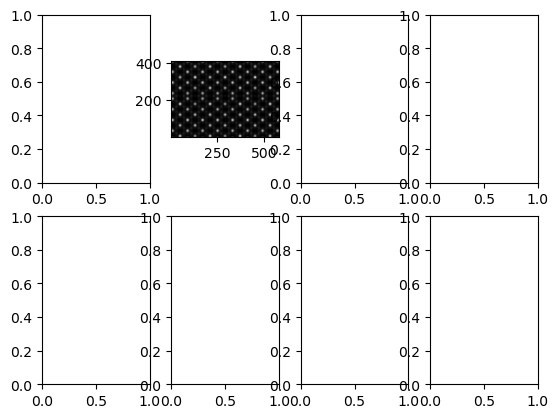

In [16]:
# Plot original image
# Create subplots
fig, ax = plt.subplots(2, 4)

# Plot im_val
im_val_plot = ax[0,1].imshow(im, cmap='gray', 
                           extent=[y_range[0], y_range[1], x_range[0], x_range[1]],)
#fig.colorbar(im_val_plot, ax=ax[0], extend='both')
ax[0,1].axis('equal')
ax[0,1].axis('off')

# Plot im_uv
im_uv_plot = ax[0,1].imshow(sig_u,
                          cmap='Reds',
                          vmin = 0.5,
                          vmax=0.8,
                          extent=[y_range[0], y_range[1], x_range[0], x_range[1]])
#fig.colorbar(im_uv_plot, ax=ax[1], extend='both')
ax[0,11].axis('off')

im_uv_plot = ax[1,0].imshow(sig_v,
                          cmap = 'Blues',
                          vmin = 0.5,
                          vmax=0.8,
                          extent=[y_range[0], y_range[1], x_range[0], x_range[1]])
#fig.colorbar(im_uv_plot, ax=ax[2], extend='both')
ax[1,0].axis('equal')
ax[1,0].axis('off')

# Plot Fourier transform with circles
qv_color_blue = (0.031,0.188,0.420)

# Apply FFT shift and take the absolute value
fft_show = np.fft.fftshift(np.abs(im_fft_window))

# Define the window limits
window = [-50, 50]

# Slice the FFT data to the desired window
# Assuming y_range and x_range represent the total ranges of your data
y_mid = fft_show.shape[0] // 2
x_mid = fft_show.shape[1] // 2
fft_show_window = fft_show[y_mid + window[0]:y_mid + window[1], x_mid + window[0]:x_mid + window[1]]

# Plot the sliced FFT data with the adjusted extent
im_fft_plot = ax[1,1].imshow(fft_show, extent=[window[0], window[1], window[0], window[1]], cmap='gray_r')

# Plotting the circles
ax[1,1].plot(st*qr*scale_circle + qu[1]/2, ct*qr*scale_circle + qu[0]/2, color='red', linewidth=1)
ax[1,1].plot(st*qr*scale_circle + qv[1]/2, ct*qr*scale_circle + qv[0]/2, color=qv_color_blue, linewidth=1)

im_fft_plot.set_clim(int_fft)
ax[1,1].axis('equal')
ax[1,1]].axis('off')

fig.tight_layout()

os.system(f'cp Filtered_results.pdf Filtered_results_old.pdf')
fig.savefig('Filtered_results.pdf')

In [11]:
im.shape

(411, 582)